# Predictions based on features
Test models both on the 8 class and the two-class classification problems. Grid search for parameters for 2 and and 8 class.

This is based off of http://ieeexplore.ieee.org.proxy.lib.uwaterloo.ca/stamp/stamp.jsp?arnumber=7312934, where they use a five-fold cross validation with the 5 train and test sets already defined by them. The hyperparameter tuning is done using a random subset of the training set (without dividing by patient)

Models Used:
1. Logistic Regression
2. Random Forest
3. XGBoost 
4. KNN
5. SVM

Another method is to extract patches from the orignial image to train the neural net on. For testing the predictions of multiple patches can be averaged.

In [3]:
import os
import sys
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score

% matplotlib inline

sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/breakHis/src')
from models import*

# load the train data
train_features = np.load('/Users/rb/Documents/waterloo/projects/breakHis/features/vgg/fold1/100/train/train_feat_vgg_100_aug1.npy')
print('train_features.shape', train_features.shape)

y_train = train_features[:,:8]
x_train = train_features[:,8:]

# Make y-values indicating benign vs. malignant
y_bin_train = np.zeros((y_train.shape[0],2))
for index, row in enumerate(y_train):
    if(np.sum(row[:4])>0):
        y_bin_train[index, :] = 0
        y_bin_train[index, 0] = 1
    else:
        y_bin_train[index, :] = 0
        y_bin_train[index, 1] = 1
         
# load the valid data
valid_features = np.load('/Users/rb/Documents/waterloo/projects/breakHis/features/vgg/fold1/100/valid/valid_feat_vgg_100_aug1.npy')
print('valid_features.shape', valid_features.shape)
y_valid = valid_features[:,:8]
x_valid = valid_features[:,8:]

# Make y-values indicating benign vs. malignant
y_bin_valid = np.zeros((y_valid.shape[0],2))
for index, row in enumerate(y_valid):
    if(np.sum(row[:4])>0):
        y_bin_valid[index, :] = 0
        y_bin_valid[index, 0] = 1
    else:
        y_bin_valid[index, :] = 0
        y_bin_valid[index, 1] = 1

# get rid of hot-one
y_bin_train = np.argmax(y_bin_train, axis=1)
y_bin_valid = np.argmax(y_bin_valid, axis=1)
y_8_train = np.argmax(y_train, axis=1)
y_8_valid = np.argmax(y_valid, axis=1)

Using TensorFlow backend.
/Users/rb/anaconda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:211: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  arg_spec = inspect.getargspec(func)
/Users/rb/anaconda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:211: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  arg_spec = inspect.getargspec(func)
/Users/rb/anaconda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:211: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  arg_spec = inspect.getargspec(func)
/Users/rb/anaconda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:211: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  arg_spec = inspect.getargspec(func)
/Users/rb/anaconda/lib/python3

train_features.shape (7728, 4104)
valid_features.shape (2856, 4104)


# Hyperparameter Search
* Using the validation set, find the best hyperparameters for each of the models

## Logistic Regression

In [32]:
import random
from random import randint
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


C_list = [.1, .2, .5, .8, 1, 1.5, 2, 4, 8, 16]
results_2 = pd.DataFrame(index=range(len(C_list)), columns=['valid_acc', 'train_acc', 'C' ])
results_8 = pd.DataFrame(index=range(len(C_list)), columns=['valid_acc', 'train_acc', 'C' ])


for i, C in enumerate(C_list):
    clf = LogisticRegression(C=C)
    clf.fit(x_train, y_bin_train)

    #train acc
    y_pred = clf.predict(x_train)
    train_acc = accuracy_score(y_bin_train, y_pred)
    # check test acc
    y_pred = clf.predict(x_valid)
    valid_acc=accuracy_score(y_bin_valid, y_pred)
    results_2.loc[i] = [valid_acc, train_acc, C]
    
    # For 8 class: 
    clf.fit(x_train, y_8_train)
    y_pred = clf.predict(x_train)
    train_acc = accuracy_score(y_8_train, y_pred)
    y_pred = clf.predict(x_valid)
    valid_acc=accuracy_score(y_8_valid, y_pred)
    results_8.loc[i] = [valid_acc, train_acc, C]  
    
results_2 = results_2.sort_values(['valid_acc'], ascending=False)
results_8 = results_8.sort_values(['valid_acc'], ascending=False)
print("Binary Classification:")
display(results_2)
print("8 Class:")
display(results_8)

Binary Classification:


,valid_acc,train_acc,C
0,0.823179,0.899974,0.1
1,0.822829,0.914079,0.2
2,0.818627,0.930254,0.5
3,0.815126,0.938794,0.8
4,0.814426,0.942935,1
5,0.810574,0.949017,1.5
6,0.809524,0.953546,2
7,0.803922,0.964415,4
8,0.795868,0.97619,8
9,0.794818,0.985637,16


8 Class:


,valid_acc,train_acc,C
4,0.47584,0.90942,1
3,0.47514,0.897386,0.8
2,0.47444,0.8772,0.5
1,0.470938,0.834757,0.2
6,0.470938,0.936594,2
5,0.470588,0.926242,1.5
0,0.468487,0.804477,0.1
7,0.468487,0.957816,4
8,0.463936,0.976708,8
9,0.459034,0.986801,16


## Random Forest

In [33]:
import random
from random import randint
from sklearn.ensemble import RandomForestClassifier
n_iter_search = 20
results_2 = pd.DataFrame(index=range(n_iter_search), columns=['valid_acc', 'train_acc', 'n_estimators',  'min_samples_split'])
results_8 = pd.DataFrame(index=range(n_iter_search), columns=['valid_acc', 'train_acc', 'n_estimators',  'min_samples_split'])

for i in range(n_iter_search):
    n_estimators = random.choice([5, 10, 20, 40, 80, 160, 320])
    min_samples_split = random.choice([2, 3, 4])
    
    clf = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split)
    clf.fit(x_train, y_bin_train)

    #train acc
    y_pred = clf.predict(x_train)
    train_acc = accuracy_score(y_bin_train, y_pred)
    # check test acc
    y_pred = clf.predict(x_valid)
    valid_acc=accuracy_score(y_bin_valid, y_pred)
    results_2.loc[i] = [valid_acc, train_acc, n_estimators, min_samples_split]
    
    # For 8 class: 
    clf.fit(x_train, y_8_train)
    y_pred = clf.predict(x_train)
    train_acc = accuracy_score(y_8_train, y_pred)
    y_pred = clf.predict(x_valid)
    valid_acc=accuracy_score(y_8_valid, y_pred)
    results_8.loc[i] = [valid_acc, train_acc, n_estimators, min_samples_split]
    
results_2 = results_2.sort(['valid_acc'], ascending=False)
results_8 = results_8.sort(['valid_acc'], ascending=False)
print("Binary Classification:")
display(results_2)
print("8 Class:")
display(results_8)

Binary Classification:


/Users/rb/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/rb/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,valid_acc,train_acc,n_estimators,min_samples_split
15,0.745098,1,160,3
1,0.745098,1,320,3
5,0.744748,1,320,2
13,0.742647,1,320,3
16,0.741597,1,160,3
18,0.740896,1,80,2
4,0.735994,1,40,3
14,0.735644,0.999871,40,4
6,0.730742,0.999741,40,4
10,0.729342,1,40,2


8 Class:


,valid_acc,train_acc,n_estimators,min_samples_split
12,0.409664,0.997412,20,4
18,0.408613,1,80,2
5,0.408263,1,320,2
9,0.407563,0.9956,20,4
13,0.406162,1,320,3
16,0.405812,1,160,3
15,0.405462,1,160,3
1,0.405462,1,320,3
19,0.404762,0.997412,20,4
10,0.403711,1,40,2


## XGBOOST

In [4]:
import random
from random import randint
import xgboost as xgb
from xgboost import XGBClassifier


n_iter_search = 10
results_2 = pd.DataFrame(index=range(n_iter_search), columns=['valid_acc', 'train_acc', 'n_est' , 'max_depth', 'lr', 'rlambda'])
results_8 = pd.DataFrame(index=range(n_iter_search), columns=['valid_acc', 'train_acc', 'n_est' , 'max_depth', 'lr', 'rlambda'])

for i in range(n_iter_search):
    print(i)
    n_estimators = random.choice([50, 100, 150, 200])
    max_depth = randint(3, 10)
    learning_rate = random.uniform(0.05, 0.5) 
    reg_lambda = random.uniform(0.1, 3.0)

    clf = xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, 
                            objective='binary:logistic', booster='gbtree',
                            gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
                            colsample_bylevel=1, reg_alpha=0, reg_lambda=reg_lambda)
    clf.fit(x_train, y_bin_train)

    #train acc
    y_pred = clf.predict(x_train)
    train_acc = accuracy_score(y_bin_train, y_pred)
    # check test acc
    y_pred = clf.predict(x_valid)
    valid_acc=accuracy_score(y_bin_valid, y_pred)
    results_2.loc[i] = [valid_acc, train_acc, n_estimators, max_depth, learning_rate, reg_lambda]
    
    # For 8 class:
    clf.fit(x_train, y_8_train)
    y_pred = clf.predict(x_train)
    train_acc = accuracy_score(y_8_train, y_pred)
    y_pred = clf.predict(x_valid)
    valid_acc=accuracy_score(y_8_valid, y_pred)
    results_8.loc[i] = [valid_acc, train_acc, n_estimators, max_depth, learning_rate, reg_lambda]
    
results_2 = results_2.sort_values(['valid_acc'], ascending=False)
results_8 = results_8.sort_values(['valid_acc'], ascending=False)
print("Binary Classification:")
display(results_2)
print("8 Class:")
display(results_8)

0
1
2
3
4
5
6
7
8
9
Binary Classification:


,valid_acc,train_acc,n_est,max_depth,lr,rlambda
6,0.794118,1,200,8,0.325502,2.23694
7,0.787815,0.999353,100,5,0.144127,2.66774
8,0.781513,1,100,8,0.471429,2.74278
0,0.781162,1,100,6,0.408871,2.2269
5,0.780812,1,150,8,0.240164,0.696395
3,0.778711,1,150,5,0.120132,1.1016
2,0.777661,1,50,9,0.328695,0.284241
9,0.777661,1,200,9,0.212176,1.97373
4,0.772759,1,50,10,0.262587,2.86738
1,0.769258,1,150,9,0.0727801,2.82067


8 Class:


,valid_acc,train_acc,n_est,max_depth,lr,rlambda
6,0.444678,1,200,8,0.325502,2.23694
9,0.438375,1,200,9,0.212176,1.97373
8,0.437325,1,100,8,0.471429,2.74278
0,0.436975,1,100,6,0.408871,2.2269
5,0.436625,1,150,8,0.240164,0.696395
1,0.434524,1,150,9,0.0727801,2.82067
3,0.432773,1,150,5,0.120132,1.1016
4,0.432423,1,50,10,0.262587,2.86738
7,0.429972,1,100,5,0.144127,2.66774
2,0.42507,1,50,9,0.328695,0.284241


## KNN

In [5]:
import random
from random import randint
from sklearn.neighbors import KNeighborsClassifier
n_iter_search = 10
results_2 = pd.DataFrame(index=range(n_iter_search), columns=['valid_acc', 'train_acc', 'n_neighbors'])
results_8 = pd.DataFrame(index=range(n_iter_search), columns=['valid_acc', 'train_acc', 'n_neighbors'])

for i in range(1, n_iter_search):
    n_neighbors = i
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(x_train, y_bin_train)

    #train acc
    y_pred = clf.predict(x_train)
    train_acc = accuracy_score(y_bin_train, y_pred)
    # check test acc
    y_pred = clf.predict(x_valid)
    valid_acc=accuracy_score(y_bin_valid, y_pred)
    results_2.loc[i] = [valid_acc, train_acc, n_neighbors]
    
    # For 8 class: 
    clf.fit(x_train, y_8_train)
    y_pred = clf.predict(x_train)
    train_acc = accuracy_score(y_8_train, y_pred)
    y_pred = clf.predict(x_valid)
    valid_acc=accuracy_score(y_8_valid, y_pred)
    results_8.loc[i] = [valid_acc, train_acc, n_neighbors]
    
results_2 = results_2.sort_values(['valid_acc'], ascending=False)
results_8 = results_8.sort_values(['valid_acc'], ascending=False)
print("Binary Classification:")
display(results_2)
print("8 Class:")
display(results_8)

Binary Classification:


,valid_acc,train_acc,n_neighbors
9,0.759454,0.924819,9
7,0.756303,0.9353,7
5,0.746849,0.942288,5
8,0.742297,0.933747,8
3,0.730042,0.960792,3
6,0.726891,0.943582,6
1,0.715336,1,1
4,0.710434,0.950181,4
2,0.658263,0.957816,2
0,NaN,NaN,NaN


8 Class:


,valid_acc,train_acc,n_neighbors
9,0.410014,0.84472,9
8,0.40021,0.854167,8
7,0.39881,0.863095,7
6,0.392507,0.871765,6
4,0.387605,0.891563,4
5,0.386555,0.879529,5
3,0.367297,0.912267,3
1,0.355042,1,1
2,0.34979,0.903986,2
0,NaN,NaN,NaN


## SVM

In [ ]:
import random
from random import randint
from sklearn.svm import SVC
n_iter_search = 10
results_2 = pd.DataFrame(index=range(n_iter_search), columns=['valid_acc', 'train_acc', 'C',  'kernel', 'degree'])
results_8 = pd.DataFrame(index=range(n_iter_search), columns=['valid_acc', 'train_acc', 'C',  'kernel', 'degree'])

for i in range(n_iter_search):
    print(i)
    C = random.choice([.1, .2, .5, 1, 2, 4, 8])
    kernel = random.choice(['linear', 'poly', 'rbf', 'sigmoid'])
    degree = random.choice([2, 4])
    
    clf = SVC(C=C, kernel=kernel, degree=degree)
    clf.fit(x_train, y_bin_train)

    #train acc
    y_pred = clf.predict(x_train)
    train_acc = accuracy_score(y_bin_train, y_pred)
    # check test acc
    y_pred = clf.predict(x_valid)
    valid_acc=accuracy_score(y_bin_valid, y_pred)
    results_2.loc[i] = [valid_acc, train_acc, C, kernel, degree]
    
    # For 8 class: 
    clf.fit(x_train, y_8_train)
    y_pred = clf.predict(x_train)
    train_acc = accuracy_score(y_8_train, y_pred)
    y_pred = clf.predict(x_valid)
    valid_acc=accuracy_score(y_8_valid, y_pred)
    results_8.loc[i] = [valid_acc, train_acc, C, kernel, degree]
    
results_2 = results_2.sort_values(['valid_acc'], ascending=False)
results_8 = results_8.sort_values(['valid_acc'], ascending=False)
print("Binary Classification:")
display(results_2)
print("8 Class:")
display(results_8)

# Test Set
* For binary and and 8 class
* Using best hyperparameters found above
* Training is done using the full training set, with no validation set.

In [4]:
def cv(model_2, model_8):
    import itertools
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix

    results_2 = pd.DataFrame(index=range(5), columns=['test_acc', 'train_acc', 'fold'])
    results_8 = pd.DataFrame(index=range(5), columns=['test_acc', 'train_acc', 'fold'])

    for i in range(5):
        fold = 'fold'+str(i+1)
        print('Fold ', i )
        # load the train data
        train_feat_loc='/Users/rb/Documents/waterloo/projects/breakHis/features/vgg/'+fold+'/100/train/train_feat_vgg_100_aug1.npy'
        valid_feat_loc='/Users/rb/Documents/waterloo/projects/breakHis/features/vgg/'+fold+'/100/valid/valid_feat_vgg_100_aug1.npy'

        train_features = np.load(train_feat_loc)
        valid_features = np.load(valid_feat_loc)
        train_features = np.concatenate((train_features, valid_features), axis=0)
        y_train = train_features[: ,:8]
        x_train = train_features[: ,8:]

        # Make y-values indicating benign vs. malignant
        y_bin_train = np.zeros((y_train.shape[0],2))
        for index, row in enumerate(y_train):
            if(np.sum(row[:4])>0):
                y_bin_train[index, :] = 0
                y_bin_train[index, 0] = 1
            else:
                y_bin_train[index, :] = 0
                y_bin_train[index, 1] = 1

        # load the test data
        test_features = np.load('/Users/rb/Documents/waterloo/projects/breakHis/features/vgg/'+fold+'/100/test/test_feat_vgg_100_aug1.npy')
        y_test = test_features[:,:8]
        x_test = test_features[:,8:]

        # Make y-values indicating benign vs. malignant
        y_bin_test = np.zeros((y_test.shape[0],2))
        for index, row in enumerate(y_test):
            if(np.sum(row[:4])>0):
                y_bin_test[index, :] = 0
                y_bin_test[index, 0] = 1
            else:
                y_bin_test[index, :] = 0
                y_bin_test[index, 1] = 1

        # get rid of hot-one
        y_bin_train = np.argmax(y_bin_train, axis=1)
        y_bin_test = np.argmax(y_bin_test, axis=1)
        y_8_train = np.argmax(y_train, axis=1)
        y_8_test = np.argmax(y_test, axis=1)


        ########### 2 CLASS  ###################
        # Fit the model:
        clf = model_2
        clf.fit(x_train, y_bin_train)

        #train and test acc
        y_pred = clf.predict(x_train)
        train_acc = accuracy_score(y_bin_train, y_pred)
        y_pred_2 = clf.predict(x_test)
        test_acc=accuracy_score(y_bin_test, y_pred_2)
        results_2.loc[i] = [test_acc, train_acc, fold]


        ########### 8 CLASS  ###################
        # Fit the model:
        clf = model_8

        clf.fit(x_train, y_8_train)

        #train and test acc
        y_pred = clf.predict(x_train)
        train_acc = accuracy_score(y_8_train, y_pred)
        y_pred_8 = clf.predict(x_test)
        test_acc=accuracy_score(y_8_test, y_pred_8)
        results_8.loc[i] = [test_acc, train_acc, fold]

    print('Binary classification results:')
    display(results_2)
    print('Average Test Accc: ', results_2["test_acc"].mean())

    print('Binary Classification Confusion matrix for fold 5:')
    cm = confusion_matrix(y_bin_test, y_pred_2)
    classes = ['B', 'M']

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # add the numbers
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
    print('8-Class Classification Results:')
    display(results_8)
    print('Average Test Accc: ', results_8["test_acc"].mean())

    print('8-Class Classification Confusion matrix for fold 5:')
    cm = confusion_matrix(y_8_test, y_pred_8)
    classes = ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # add the numbers
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Logistic Regression
* Binary C=.1
* 8-class C=1

Fold  0
Fold  1
Fold  2
Fold  3
Fold  4
Binary classification results:


,test_acc,train_acc,fold
0,0.823916,0.89503,fold1
1,0.790323,0.896817,fold2
2,0.793722,0.889341,fold3
3,0.746418,0.89389,fold4
4,0.838002,0.884226,fold5


Average Test Accc:  0.798476245607
Binary Classification Confusion matrix for fold 5:


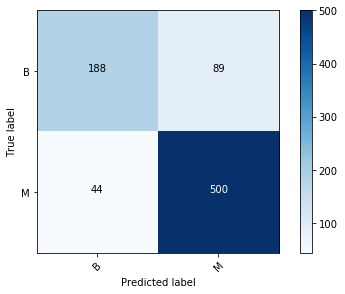

8-Class Classification Results:


,test_acc,train_acc,fold
0,0.473062,0.871032,fold1
1,0.432258,0.845055,fold2
2,0.445441,0.861278,fold3
3,0.442693,0.842733,fold4
4,0.439708,0.871032,fold5


Average Test Accc:  0.446632373064
8-Class Classification Confusion matrix for fold 5:


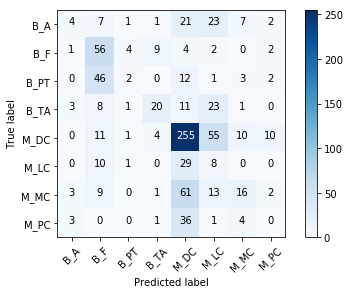

In [22]:
from sklearn.linear_model import LogisticRegression

model_2 = LogisticRegression(C=.1)
model_8 = LogisticRegression(C=1)
cv(model_2, model_8)

## Random Forest
* Binary 160, 3
* 8-class 160, 3

Fold  0
Fold  1
Fold  2
Fold  3
Fold  4
Binary classification results:


,test_acc,train_acc,fold
0,0.785808,1,fold1
1,0.735484,1,fold2
2,0.718984,1,fold3
3,0.716332,1,fold4
4,0.744214,1,fold5


Average Test Accc:  0.740164465326
Binary Classification Confusion matrix for fold 5:


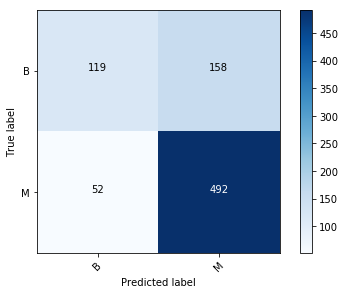

8-Class Classification Results:


,test_acc,train_acc,fold
0,0.461235,1,fold1
1,0.408065,1,fold2
2,0.421525,1,fold3
3,0.398281,1,fold4
4,0.409257,1,fold5


Average Test Accc:  0.419672440514
8-Class Classification Confusion matrix for fold 5:


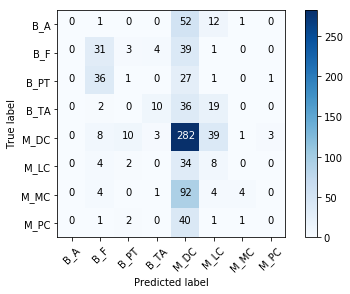

In [23]:
from sklearn.ensemble import RandomForestClassifier

model_2 = RandomForestClassifier(n_estimators=160, min_samples_split=3)
model_8 = RandomForestClassifier(n_estimators=160, min_samples_split=3)
cv(model_2, model_8)

## XGBoost
* Binary: n_estimators=200	max_depth=8	learning_rate=0.3	reg_lambda=2
* 8-class: n_estimators=250 max_depth=9 learning_rate=0.3	reg_lambda=2 (guess)

Fold  0
Fold  1
Fold  2
Fold  3
Fold  4
Binary classification results:


,test_acc,train_acc,fold
0,0.821288,1,fold1
1,0.758065,1,fold2
2,0.751868,1,fold3
3,0.733524,1,fold4
4,0.784409,1,fold5


Average Test Accc:  0.769830873612
Binary Classification Confusion matrix for fold 5:


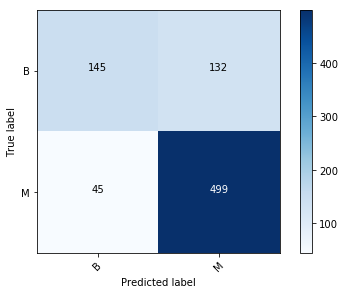

8-Class Classification Results:


,test_acc,train_acc,fold
0,0.478318,1,fold1
1,0.416129,1,fold2
2,0.415546,1,fold3
3,0.399713,1,fold4
4,0.403167,1,fold5


Average Test Accc:  0.422574592408
8-Class Classification Confusion matrix for fold 5:


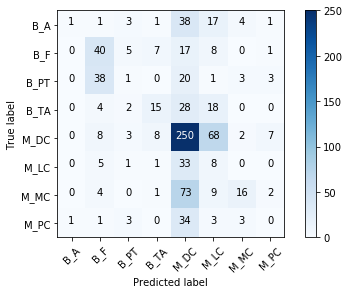

In [5]:
from xgboost import XGBClassifier

model_2 = XGBClassifier(n_estimators=200, max_depth=8, learning_rate=0.3, reg_lambda=2)
model_8 = XGBClassifier(n_estimators=200, max_depth=8, learning_rate=0.3, reg_lambda=2)
cv(model_2, model_8)

## KNN
* 9 neighbours

Fold  0
Fold  1
Fold  2
Fold  3
Fold  4
Binary classification results:


,test_acc,train_acc,fold
0,0.745072,0.91232,fold1
1,0.703226,0.910079,fold2
2,0.672646,0.916962,fold3
3,0.673352,0.906815,fold4
4,0.730816,0.915476,fold5


Average Test Accc:  0.705022466634
Binary Classification Confusion matrix for fold 5:


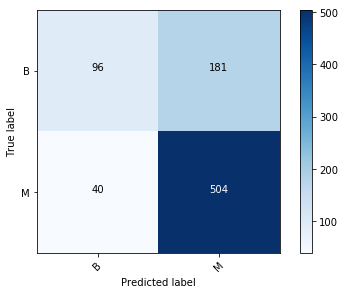

8-Class Classification Results:


,test_acc,train_acc,fold
0,0.411301,0.820389,fold1
1,0.345161,0.802533,fold2
2,0.355755,0.827018,fold3
3,0.318052,0.795192,fold4
4,0.365408,0.823214,fold5


Average Test Accc:  0.359135336614
8-Class Classification Confusion matrix for fold 5:


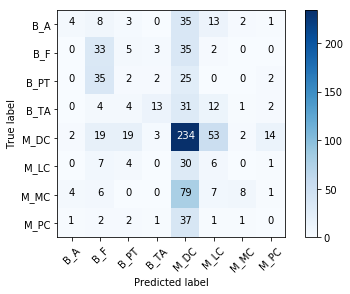

In [7]:
from sklearn.neighbors import KNeighborsClassifier

model_2 = KNeighborsClassifier(n_neighbors=9)
model_8 = KNeighborsClassifier(n_neighbors=9)
cv(model_2, model_8)